In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import matplotlib.pyplot as plt

Antes de empezar con el preprocesamiento de los datos, se seleccionan aquellas variables de interés para aplicar al modelo.

In [2]:
sanctionlist = pd.read_csv('datos_entrada_script_04_y_PowerBI/sanctionlist.csv').iloc[:,1:]
sanctionlist

,Name,EntityType,Address,Country,Origin,City
0,AEROCARIBBEAN AIRLINES,ENTERPRISE,NaN,CUBA,EEUU,HAVANA
1,"ANGLO-CARIBBEAN CO., LTD.",ENTERPRISE,"IBEX HOUSE, THE MINORIES",UNITED KINGDOM,EEUU,LONDON
2,BANCO NACIONAL DE CUBA,ENTERPRISE,ZWEIERSTRASSE 35,SWITZERLAND,EEUU,ZURICH
3,BANCO NACIONAL DE CUBA,ENTERPRISE,AVENIDA DE CONCHA ESPINA 8,SPAIN,EEUU,MADRID
4,BANCO NACIONAL DE CUBA,ENTERPRISE,"DAI-ICHI BLDG. 6TH FLOOR, 10-2 NIHOMBASHI, 2-C...",JAPAN,EEUU,TOKYO
...,...,...,...,...,...,...
25822,VIKTOR YANUKOVYCH,PERSON,NaN,NaN,UE,NaN
25823,VIKTOR FEDOROVICH YANUKOVYCH,PERSON,NaN,NaN,UE,NaN
25824,YEVHEN VITALIIOVYCH BALYTSKIY,PERSON,NaN,NaN,UE,NaN
25825,YEVGENIY VITALIEVICH BALYTSKIY,PERSON,NaN,NaN,UE,NaN


In [21]:
sanctionlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25827 entries, 0 to 25826
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        25827 non-null  object
 1   EntityType  25827 non-null  object
 2   Address     8230 non-null   object
 3   Country     14789 non-null  object
 4   Origin      25827 non-null  object
 5   City        12681 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [7]:
sanctionlist.describe()

,Name,EntityType,Address,Country,Origin,City
count,25827,25827,8230,14789,25827,12681
unique,20801,5,7099,190,2,2159
top,AERO CONTINENTE S.A,ENTERPRISE,"EAST SHAHID ATEFI STREET 35, AFRICA BOULEVARD,...",RUSSIA,EEUU,TEHRAN
freq,47,10225,30,1718,15258,986


A partir del resultado de describe() se puede estudiar la cardinalidad de cada variable:

In [18]:
for i in sanctionlist.describe().columns:
    print("La variable", i, "presenta un", round(sanctionlist.describe().loc['unique',i]/sanctionlist.describe().loc['count',i]*100,2),'% de valores únicos sobre el total de valores no nulos.\n')

La variable Name presenta un 80.54 % de valores únicos sobre el total de valores no nulos.

La variable EntityType presenta un 0.02 % de valores únicos sobre el total de valores no nulos.

La variable Address presenta un 86.26 % de valores únicos sobre el total de valores no nulos.

La variable Country presenta un 1.28 % de valores únicos sobre el total de valores no nulos.

La variable Origin presenta un 0.01 % de valores únicos sobre el total de valores no nulos.

La variable City presenta un 17.03 % de valores únicos sobre el total de valores no nulos.



A mayor porcentaje, mayor es la cardinalidad. No interesan las variables con un porcentaje de valores únicos alto porque esto podría acarrear problema de rendimiento y de calidad del modelo. Por lo tanto, se eliminarán las variables 'Name' y 'Address' del preprocesamiento.

In [3]:
ml_ns = sanctionlist.drop(columns=['Name','Address'])
ml_ns

,EntityType,Country,Origin,City
0,ENTERPRISE,CUBA,EEUU,HAVANA
1,ENTERPRISE,UNITED KINGDOM,EEUU,LONDON
2,ENTERPRISE,SWITZERLAND,EEUU,ZURICH
3,ENTERPRISE,SPAIN,EEUU,MADRID
4,ENTERPRISE,JAPAN,EEUU,TOKYO
...,...,...,...,...
25822,PERSON,NaN,UE,NaN
25823,PERSON,NaN,UE,NaN
25824,PERSON,NaN,UE,NaN
25825,PERSON,NaN,UE,NaN


Todas las variables son categóricas nominales. Hay que sustituirlas por valores numéricos por algún método de codificación. Las variables 'City' y 'Country' presentan una alta cardinalidad. Para evitar que se creen demasiadas columnas por cada variable y así evitar la 'maldición de la dimensionalidad', se utiliza BinaryEncoder (Referencia: https://elmundodelosdatos.com/tecnicas-para-codificar-variables-categoricas-binaria-hashing/) 

## Modelos No Supervisados:

Para construir los modelos, se utilizan las siguientes transformaciones:

- Un codificador a binario de todas las columnas que no modifica los valores nulos.
- Dos tipos distintos de imputador para los valores nulos: Darles valor constante 0 o aplicar el métodos de los K vecinos. 
- Un PCA que permite reducir la dimensionalidad de las variables ajustando el parámetro n_components. Se aplicará con n_components a partir de 0.85.
- Un StandardScaler para estandarizar las columnas a la salida del PCA que podrá ser o no ser aplicado.
- Algoritmo KMeans con n_init=20 para mejorar la calidad de la agrupación y n_cluster de 2 a 8. Se añade un bucle for para aplicar distintos valores de n_cluster.
- Representación gráfica de la silueta frente a número de clusters para conocer el número óptimo de grupos. Un coeficientes cercano a +1 supone instancias más metidas en su propio grupo y lejos de los otros.


## Modelo KMeans

- Modelo base:

In [12]:
list_silhouette=[]

for i in range(280,281):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
                    ('pca',PCA(n_components=0.85,random_state=25)),
                    ('std',StandardScaler())
    ])
  
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=10,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.7262648885921099]

- knn 3 vecinos, PCA 5 columnas, sin standard scaler

In [27]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=3)),
                    ('pca',PCA(n_components=5,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.45652427355907127,
 0.4658499247057561,
 0.4803688845289911,
 0.4791704080355779,
 0.49565951287730675]

- knn 2 vecinos, PCA 5 columnas,sin standard scaler

In [28]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=2)),
                    ('pca',PCA(n_components=5,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.44217951587070453,
 0.45555340689483875,
 0.48377039072792927,
 0.48775124160174615,
 0.49196303326096247]

- knn 3 vecinos, PCA 4 columnas, no standrs (candidato)

In [4]:
list_silhouette=[]

for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=3)),
                    ('pca',PCA(n_components=4,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.525911704777609,
 0.5288147093424547,
 0.4985340104118296,
 0.5158582531223214,
 0.49725957741730953,
 0.5007488682982777,
 0.5007414106073772]

- Candidato pero aplicando minibatch PCA con 4 componentes (el mejor)

In [17]:
from sklearn.decomposition import MiniBatchSparsePCA

list_silhouette=[]
for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=3)),
                    ('minibatch',MiniBatchSparsePCA(n_components=4, batch_size=15,random_state=0))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.5196696294700993,
 0.5407875109812468,
 0.4924985656410125,
 0.5202817419727904,
 0.5011263075805212,
 0.5057485815662492,
 0.5054378633578627]

For n_clusters = 2 The average silhouette_score is : 0.5196696294700993
For n_clusters = 3 The average silhouette_score is : 0.5407875109812468
For n_clusters = 4 The average silhouette_score is : 0.4924985656410125
For n_clusters = 5 The average silhouette_score is : 0.5202817419727904
For n_clusters = 6 The average silhouette_score is : 0.5011263075805212


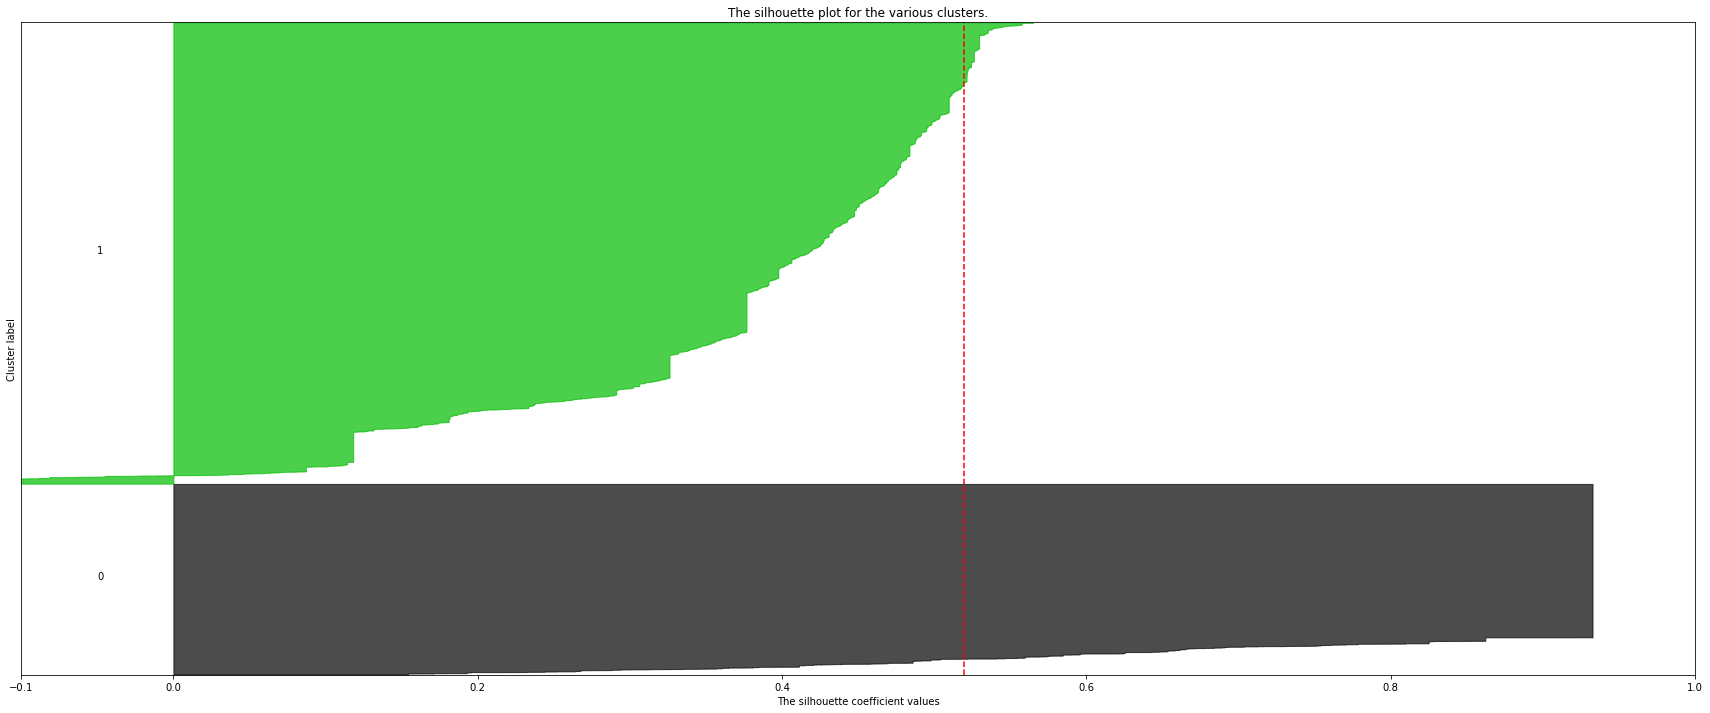

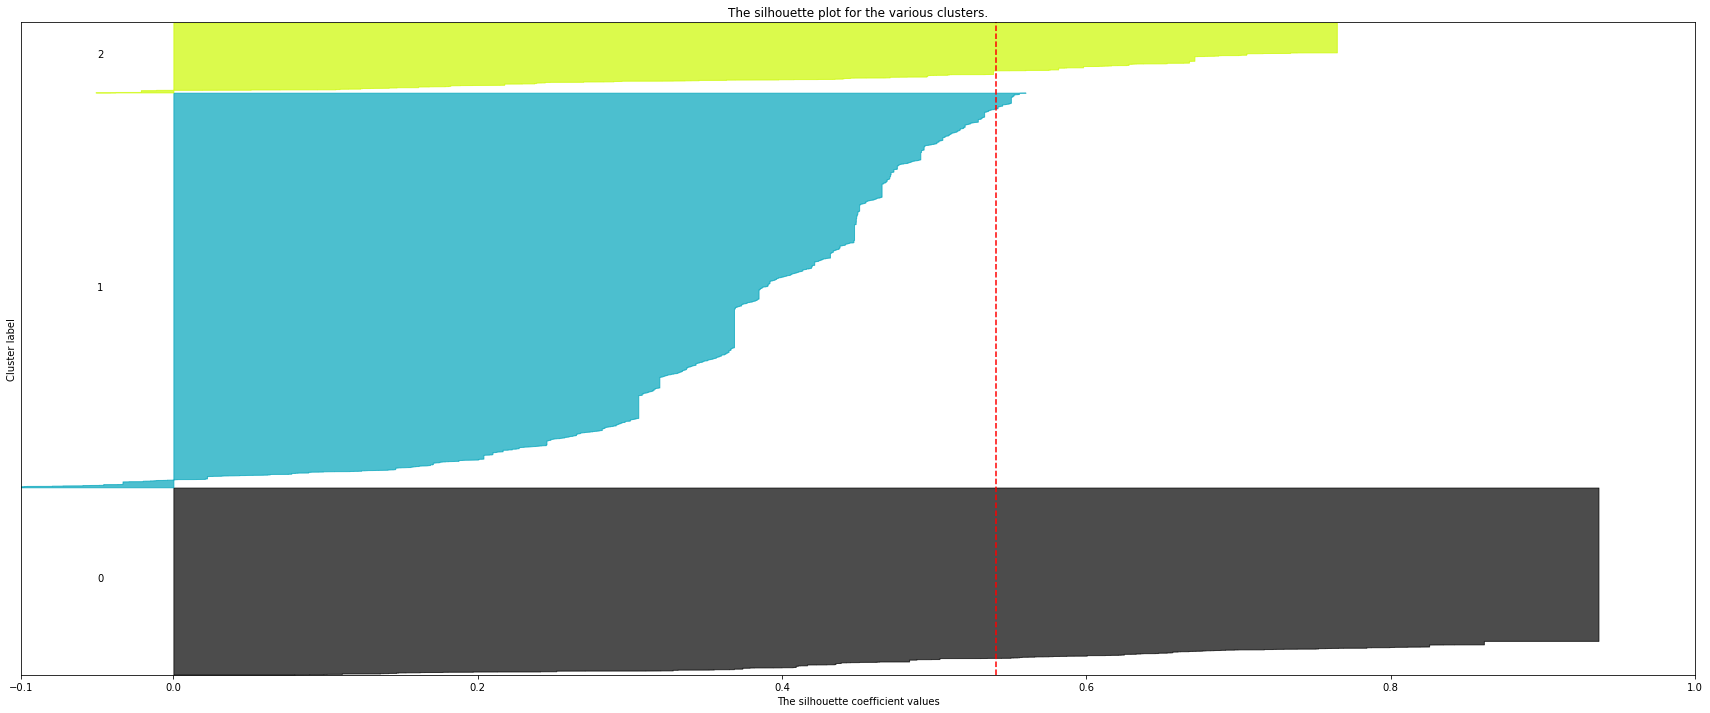

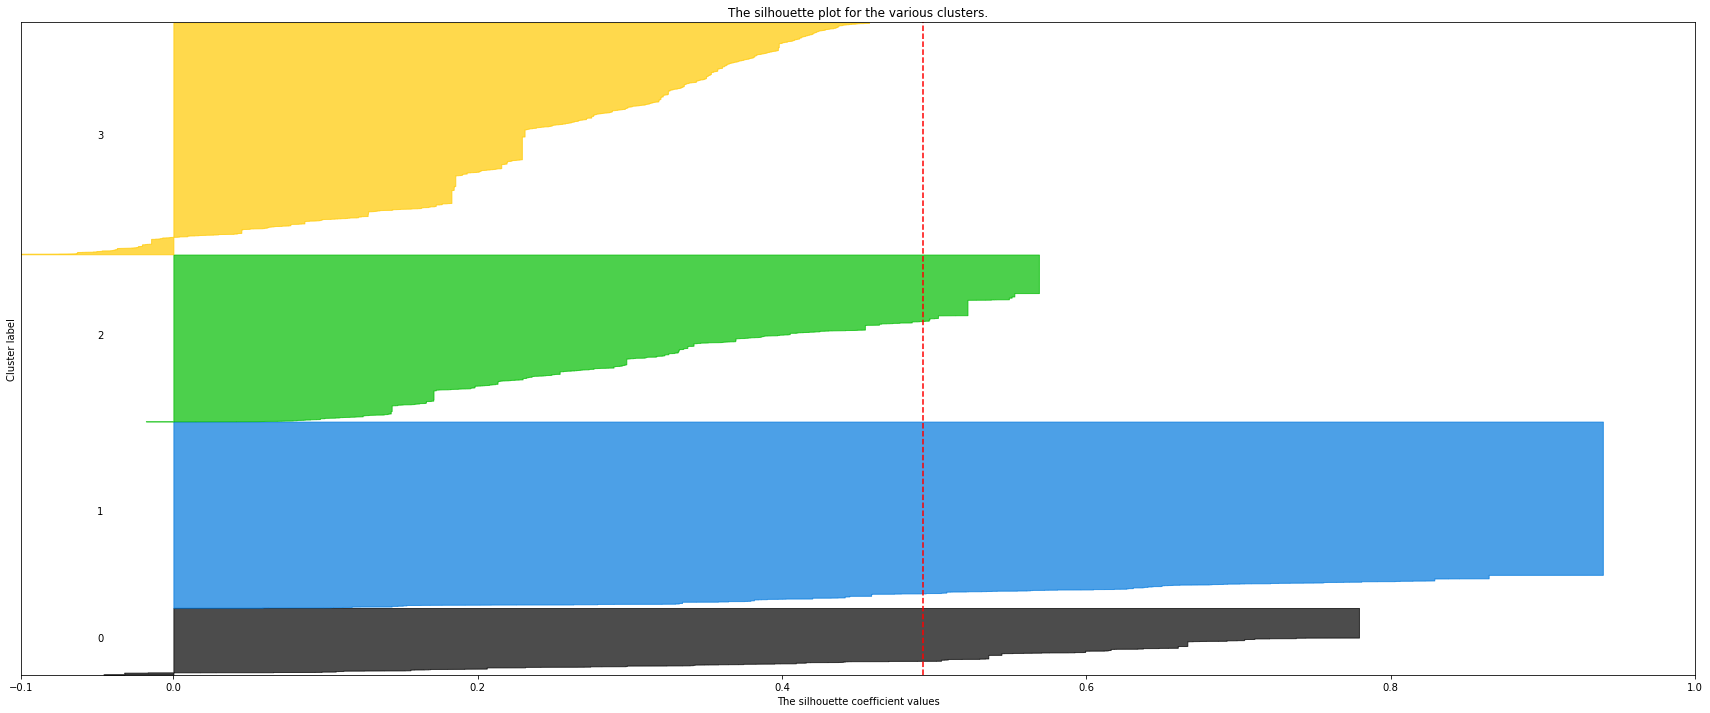

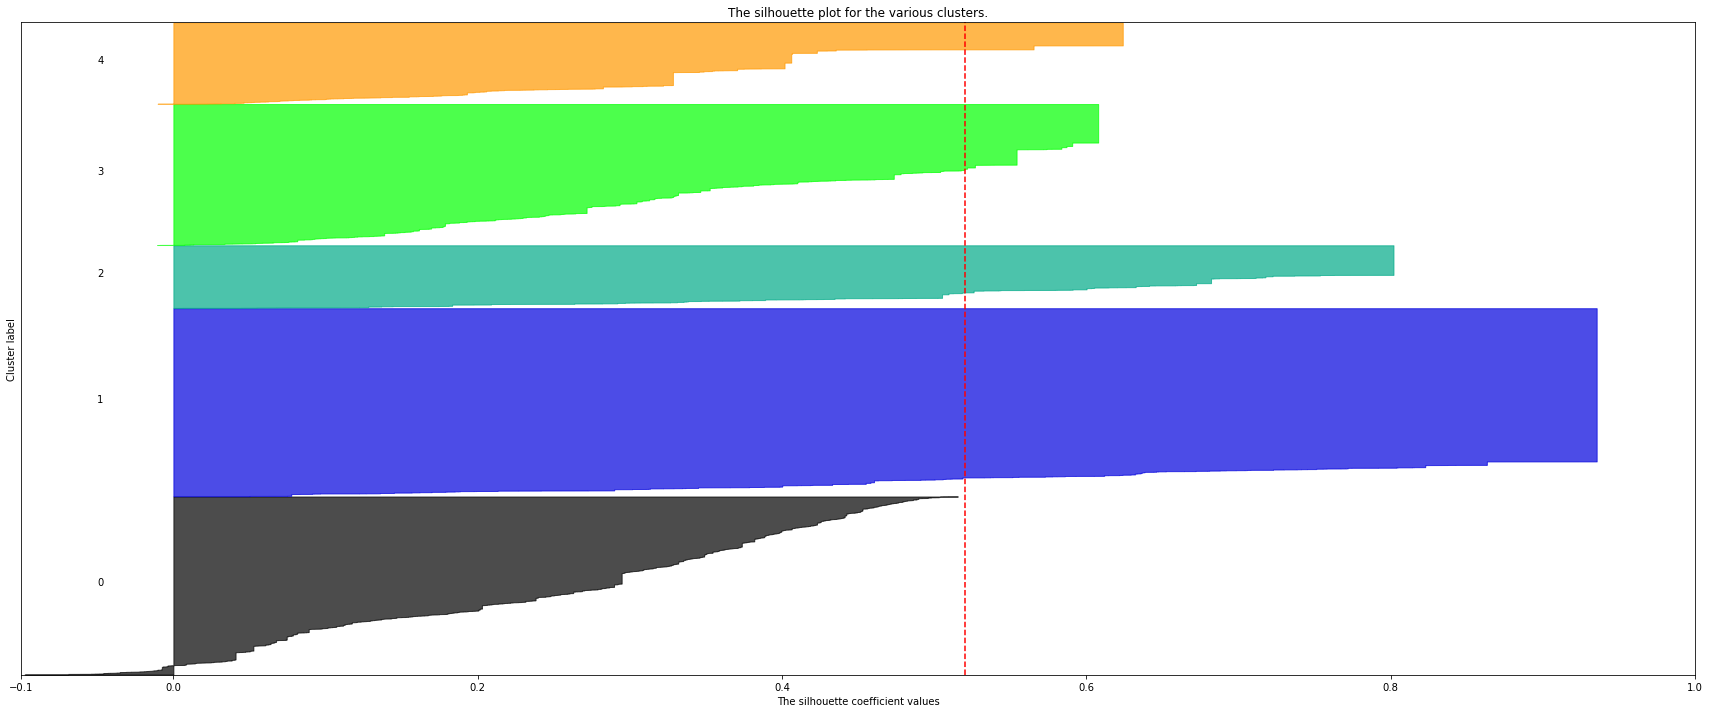

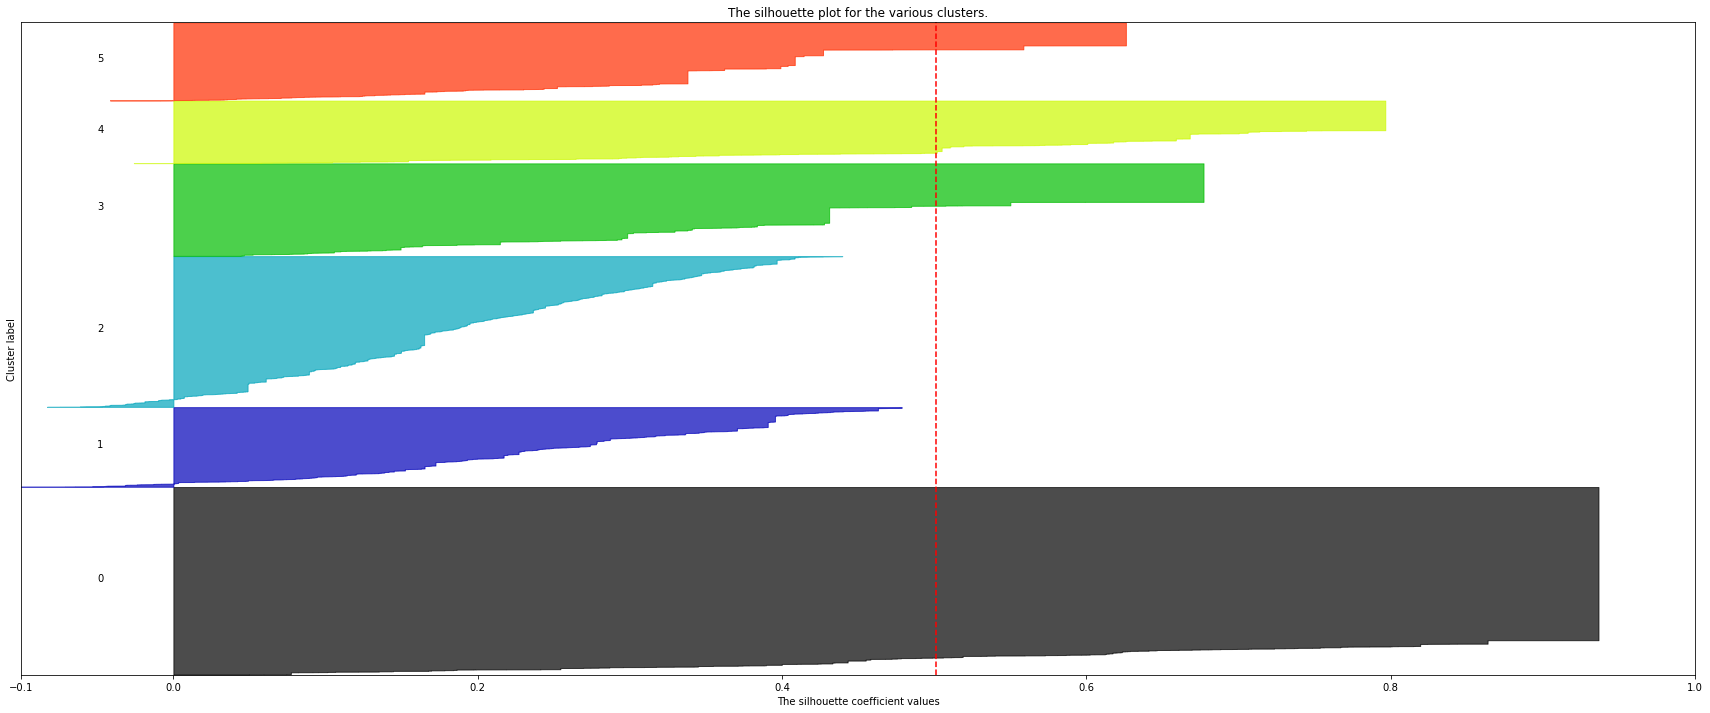

In [53]:
for n_clusters in range(2,7):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(30, 12)

    X = preprocessing_transform

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters,n_init=20,random_state=25)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

   
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



Se descubre que hay muchos puntos con la misma silueta. Esto lleva a pensar que puede haber valores dupicados. Se comprueba que esto es así. El problema es que KNNImputer está generando duplicados para n_neighbors = 3

Se prueba sin KNNneighbors:

In [66]:
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.cluster import MiniBatchKMeans

preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
                    ('minibatch',MiniBatchSparsePCA(n_components=4, batch_size=15,random_state=0))
    ])
    
preprocessing_transform = preprocessing.fit_transform(ml_ns)

list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.4351135954527987,
 0.4537807953468041,
 0.46523266595662743,
 0.47092140526041554,
 0.48943683756309414]

In [67]:
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.cluster import MiniBatchKMeans

preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',SimpleImputer(strategy='m')),
                    ('minibatch',MiniBatchSparsePCA(n_components=4, batch_size=15,random_state=0))
    ])
    
preprocessing_transform = preprocessing.fit_transform(ml_ns)

list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.4251434505545345,
 0.45424757674211064,
 0.45949732339986676,
 0.4520055579442552,
 0.4740214864064434]

- Candidato pero aplicando kernel PCA poly

In [10]:
from sklearn.decomposition import KernelPCA


for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=3)),
                    ('kernel',KernelPCA(n_components=4, kernel='poly'))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.525911704777609,
 0.5288147093424547,
 0.4985340104118296,
 0.5158582531223214,
 0.49725957741730953,
 0.5007488682982777,
 0.5007414106073772,
 0.49112863779228916,
 0.49678286865276094,
 0.4528087884795436,
 0.4630545636585885,
 0.4819278710909895,
 0.48453573254705196,
 0.4949102255810421,
 0.43541440239843143,
 0.4359328969827097,
 0.4298635006047012,
 0.4352137932870659,
 0.4366476084248089,
 0.4575717431052058,
 0.47880545090936427,
 0.4356081510829656,
 0.39113293585781994,
 0.4248266960475686,
 0.4342855429621922,
 0.44946969329546005,
 0.457887392535213,
 0.471796838192834,
 0.5307169952647802,
 0.5369713083279907,
 0.4919560284229937,
 0.5104354742307398,
 0.49683971882884165,
 0.498383395208094,
 0.5030002208058272,
 0.5520175905010418,
 0.5293990496536342,
 0.5023375832507306,
 0.526314318533586,
 0.5044179316347047,
 0.5082597259042679,
 0.506937864120966]

- Candidato pero con PCA incrmental de 7 componentes

In [11]:
from sklearn.decomposition import IncrementalPCA

list_silhouette = []
for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=3)),
                    ('incremental',IncrementalPCA(n_components=4, batch_size=200))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.5281231542832958,
 0.48355268769486187,
 0.5153195029525734,
 0.5273451692297888,
 0.5078247771316299,
 0.5192577901918021,
 0.5259427797378081]

In [41]:
list_silhouette=[] 

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=5)),
                    ('pca',PCA(n_components=4,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.49053823194193436,
 0.496257008657829,
 0.5147591475751456,
 0.5111851769968545,
 0.5260160437116843]

In [31]:
list_silhouette=[]

for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=2)),
                    ('pca',PCA(n_components=4,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.5453104743239942,
 0.5145757402260165,
 0.478839544568327,
 0.4883587290901224,
 0.4994027163611089,
 0.5071731735762348,
 0.5137947680182198]

In [32]:
list_silhouette=[]

for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=4)),
                    ('pca',PCA(n_components=4,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.5275311366245219,
 0.4822308416175853,
 0.4837755334553533,
 0.5040682212254165,
 0.5105152353706128,
 0.5229778008525402,
 0.516559296839584]

- knn 2 vecinos, PCA 4 columnas, no std

In [30]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=2)),
                    ('pca',PCA(n_components=4,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.478839544568327,
 0.4883587290901224,
 0.4994027163611089,
 0.5071731735762348,
 0.5137947680182198]

- knn de 8 vecinos, PCA a 0.75 de varianza, sin standard scaler

In [18]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=8)),
                    ('pca',PCA(n_components=0.75,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.38992958359993973,
 0.40052783290572797,
 0.41309746016640936,
 0.4196460762926436,
 0.42320854315058215]

- knn de 8 vecinos, PCA a 0.85 de varianza, sin standard scaler

In [19]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=8)),
                    ('pca',PCA(n_components=0.85,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.36656188804518447,
 0.37306180477663514,
 0.38461508051870363,
 0.39099581879560563,
 0.4011149776646517]

- knn de 8 vecinos, sin PCA, sin standard scaler

In [20]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=8))
                    #('pca',PCA(n_components=0.85,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.33835046625839116,
 0.34167568948885507,
 0.34983764660571276,
 0.36001689799407843,
 0.37338524134634493]

- knn de 5 vecinos, PCA 0.85, algorithm 'elkan', sin standard scaler

In [21]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=5)),
                    ('pca',PCA(n_components=0.85,random_state=25))
                    #('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25,algorithm='elkan').fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.369518279052965,
 0.3746797393598895,
 0.38992462486138874,
 0.40847236990885966,
 0.41532445204339924]

- knn 5 vecinos, PCA 0.85, algorithm 'elkan', con standard scaler 

In [22]:
list_silhouette=[]

for i in range(4,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',KNNImputer(n_neighbors=5)),
                    ('pca',PCA(n_components=0.85,random_state=25)),
                    ('std',StandardScaler())
    ])
    
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25,algorithm='elkan').fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.1616412473070992,
 0.2199586654900211,
 0.25072705419623836,
 0.27761505665803143,
 0.3004704724830353]

# Modelo DBSCAN

In [13]:
from sklearn.cluster import DBSCAN

for epsilon in list(np.arange(0.05,0.2,0.05)):
    
    X = preprocessing_transform
    db = DBSCAN(eps=epsilon, min_samples=10).fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Value of epsilon: %d" % epsilon)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f \n" % silhouette_score(X, labels))

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 



In [14]:
from sklearn.cluster import DBSCAN

for epsilon in list(np.arange(0.05,0.2,0.05)):
    
    X = preprocessing_transform
    db = DBSCAN(eps=epsilon, min_samples=10).fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Value of epsilon: %d" % epsilon)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f \n" % silhouette_score(X, labels))

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 

Value of epsilon: 0
Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683 



In [16]:
X = preprocessing_transform
db = DBSCAN(eps=0., min_samples=10).fit(X)

labels = db.labels_

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

Estimated number of clusters: 262
Estimated number of noise points: 5458
Silhouette Coefficient: 0.683


In [21]:
copy = pd.DataFrame(preprocessing_transform)

In [22]:
clusters = db.fit_predict(X)
copy['outliers'] = clusters

In [23]:
copy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,outliers
0,0.065581,-0.374916,0.013742,-0.120134,-1.691598,-1.353276,0.677117,-1.755490,-0.055785,-0.118843,-1.264144,-1.483299,-0.371795,-0.927010,0
1,-0.033747,-0.185612,0.660492,-0.381012,0.170788,0.029112,1.191181,-1.837854,-2.602356,-0.945289,-0.464541,1.097669,0.545799,0.367995,1
2,0.416550,0.143841,0.071241,-0.496225,-0.333563,-1.142748,0.657079,-2.525530,-1.363073,-1.105652,-2.151478,-0.117218,0.982558,-0.811332,-1
3,0.016069,-0.344288,-0.162621,0.221824,-0.175334,-0.765834,2.244408,-0.655623,-0.379390,-0.212299,0.418200,0.158713,-2.546830,0.110127,-1
4,0.466365,-0.014834,-0.751872,0.106610,-0.679684,-1.937694,1.710305,-1.343299,0.859892,-0.372662,-1.268736,-1.056173,-2.110071,-1.069201,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25822,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750,182
25823,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750,182
25824,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750,182
25825,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750,182


In [24]:
preprocessing_transform_nooutlier = copy[copy['outliers']!=-1].drop(columns=['outliers'])

In [25]:
preprocessing_transform_nooutlier

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.065581,-0.374916,0.013742,-0.120134,-1.691598,-1.353276,0.677117,-1.755490,-0.055785,-0.118843,-1.264144,-1.483299,-0.371795,-0.927010
1,-0.033747,-0.185612,0.660492,-0.381012,0.170788,0.029112,1.191181,-1.837854,-2.602356,-0.945289,-0.464541,1.097669,0.545799,0.367995
5,0.367038,0.174469,-0.105122,-0.154268,1.182702,-0.555306,2.224369,-1.425663,-1.686678,-1.199109,-0.469134,1.524794,-1.192477,0.225804
6,0.367038,0.174469,-0.105122,-0.154268,1.182702,-0.555306,2.224369,-1.425663,-1.686678,-1.199109,-0.469134,1.524794,-1.192477,0.225804
7,-0.121420,-0.626106,-0.210259,-0.318768,-0.936722,-0.602204,1.560311,-1.231191,-0.717019,0.222053,0.729954,0.406903,-0.402566,1.001797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25822,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750
25823,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750
25824,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750
25825,-1.352243,0.104772,-0.325150,0.120399,0.155951,-0.109699,-0.004220,0.146312,0.018475,0.084856,-0.091801,0.009412,0.328225,-0.080750


In [27]:
list_silhouette=[]

for i in range(2,9):
    
    kmeans = KMeans(n_clusters=i,n_init=10,random_state=25).fit(preprocessing_transform_nooutlier)
    
    silhouette = silhouette_score(preprocessing_transform_nooutlier,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.2160045292533772,
 0.23496934675111947,
 0.24719160695869416,
 0.2957663755496561,
 0.3227934609884888,
 0.34261890150133434,
 0.3668911171487957]

In [28]:
list_silhouette=[]

for i in range(2,9):
    preprocessing = Pipeline([
                    ("binary",BinaryEncoder(handle_missing='return_nan',drop_invariant=True)), 
                    ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
                    ('pca',PCA(n_components=0.85,random_state=25)),
                    ('std',StandardScaler())
    ])
  
    preprocessing_transform = preprocessing.fit_transform(ml_ns)
    
    kmeans = KMeans(n_clusters=i,n_init=10,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.13984804453563884,
 0.19695555367722775,
 0.2068885296710592,
 0.18140020907038507,
 0.20609221153681626,
 0.22488329977786614,
 0.23650483056801286]

Se pueden hacer dos datasets para el modelo: uno en el que se eliminen outliers aplicando algún modelo de preprocesamiento y otro en el que se deje que sea el modelo ML el que detecte estas anomalías si es que las considera como tal. Se pueden hacer gráficas de codo y dendogramas.

Primero se hicieron modelos usando distintos codificadores para cada columna. Para ello, en vez de  usar Pipeline se utilizó ColumnTransformer.  ColumnsTransformer funciona como Pipeline pero pudiendo seleccionar la/s columna/s sobre las que se aplica la transformación. Pero se descubrió que el mejor método para codificar todas las columnas era BinaryEncoder. Con BinaryEncoder se puede hacer que los valores nulos queden como 'nan' en vez de asignarles un código binario. Esto es importante porque así luego se pueden pasar reglas de imputación a estos valores.

Se intentó hacer un dendograma. Pero eran demasiados registros como para poderlos representar gráficamente de esta forma.